# Detecting Fake News With Data Science
By: Minna Fingerhood, Natalie Del Rossi

*import relevant packages:*

In [1]:
import minna_functions as mf
from spacy.lang.en.stop_words import STOP_WORDS
import operator
import pandas as pd
import re
import seaborn as sns
from itertools import chain
from collections import Counter
import operator
import string
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
nlp = spacy.load('en_core_web_lg')

*import data:* 

Data accessed from Kaggle, entitled "Fake News Detection" by jruvika: 

https://www.kaggle.com/jruvika/fake-news-detection

In [ ]:
df = pd.read_csv('data.csv')

*1. Clean Data:*

*(for more in depth explanation, please reference the clean_data function in minna_functions file & ReadMe)*

In [ ]:
clean_df = mf.clean_data(df)

#tokenize the body of the text for each article so that we can perform analysis
clean_df['token_body'] = [nlp(clean_df['Body'][i]) for i in range(0, len(clean_df))]

*tokenize data and seperate by fake news, real news, & total news so that we can perform EDA on the different data:*

In [ ]:
real_articles = mf.get_article_type(clean_df, 1)
fake_articles = mf.get_article_type(clean_df, 0)
real_df = mf.token_dataframe_from_dict(mf.token_words(real_articles))
fake_df = mf.token_dataframe_from_dict(mf.token_words(fake_articles))
total_counts = mf.token_dataframe_from_dict(mf.token_words(clean_df))

*2. Exploratory Data Analysis (EDA) & Visualizations:*

(a) distribution plot & also our baseline model which is roughly 50% accurate

In [ ]:
clean_df.Label.value_counts()

In [ ]:
plt.title('Fake News Articles vs. Real News')
plt.xlabel('Type of News')
plt.ylabel('Number of Articles')
ax = sns.distplot(clean_df['Label'], color='mediumpurple', bins = 3, kde = False)
ax.set_xticks([0,1])
ax.set_xticklabels(['fake', 'real'])

(b) bar chart of most common words seperated by fake news, real news, and total news:

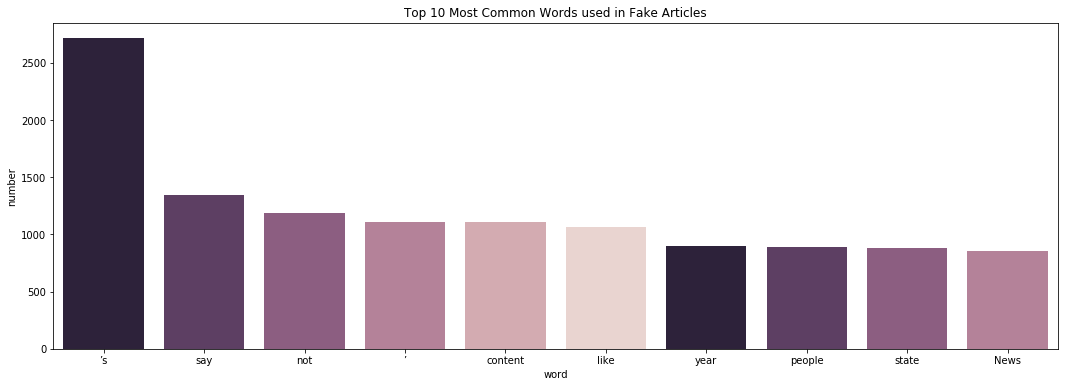

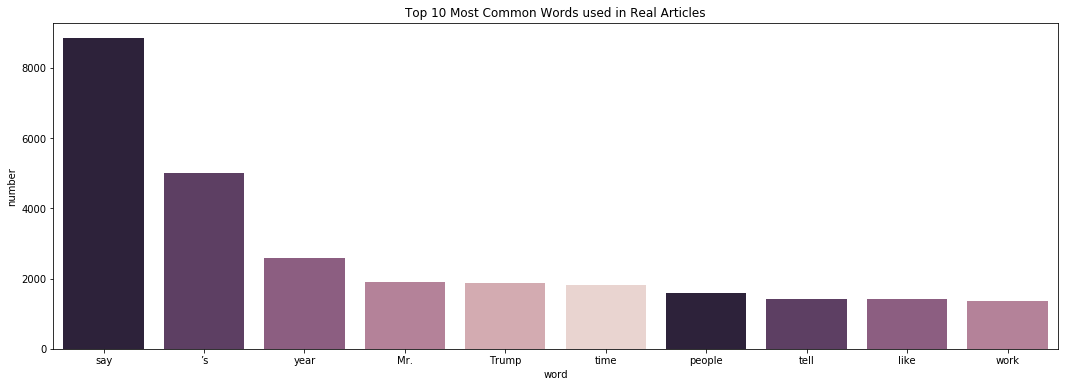

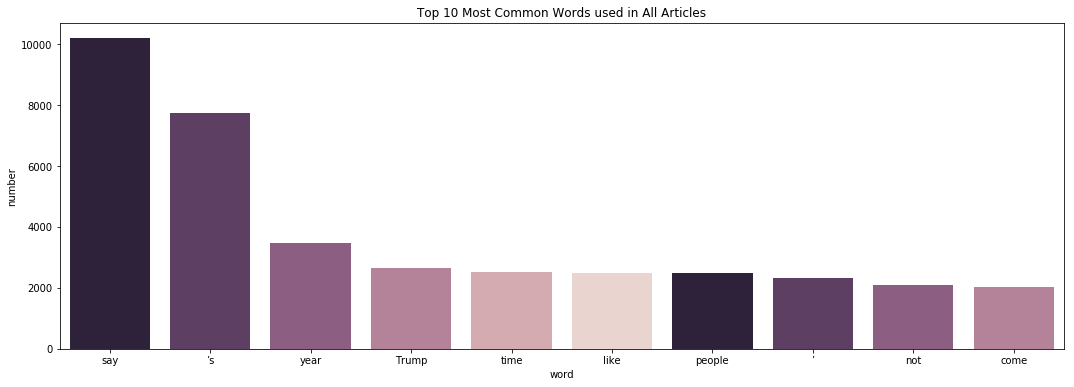

In [12]:
mf.barplot(fake_df, 'Fake')
mf.barplot(real_df, 'Real')
mf.barplot(total_counts, 'All')

*3. Modeling & Further Analysis:*

*we use tf-idf vectorization in our modeling, so must transform our data*

In [8]:
#add column for lemmatized token words
clean_df = mf.lemma(clean_df)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range = (1,2), stop_words='english')
tfidfv = tfidf.fit_transform(clean_df['lemma']).toarray()
label = clean_df.Label


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/minnafingerhood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


*train, test, and split:*

In [9]:
X_train, X_test, y_train, y_test = train_test_split(tfidfv, clean_df['Label'], 
                                                    test_size = 0.3,random_state=1)

(a) Multinomial Naive Bayes Model 

In [13]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_class = nb.predict(X_test)

In [14]:
metrics.accuracy_score(y_test, y_pred_class)
metrics.confusion_matrix(y_test, y_pred_class)

array([[381,  66],
       [  0, 511]])

In [15]:
y_pred_prob = nb.predict_proba(X_test)[:, 1]
y_pred_prob
metrics.roc_auc_score(y_test, y_pred_prob)

0.9916205886602136

In [349]:
# tfidf_df = pd.DataFrame(features)
# tfidf_df.columns = tfidf.get_feature_names()
# fake_tfidf = mf.get_article_type(tfidf_df, 0)
# real_tfidf = mf.get_article_type(tfidf_df, 1)

(b) Topic Analysis

In [16]:
real_articles = mf.lemma(real_articles)
fake_articles = mf.lemma(fake_articles)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/minnafingerhood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/minnafingerhood/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
fake_topic_analysis = mf.topic_analysis(fake_articles)
real_topic_analysis = mf.topic_analysis(real_articles)

NameError: name 'LatentDirichletAllocation' is not defined

In [ ]:
mf.display_topics(fake_topic_analysis, tf_feature_names, 10)
mf.display_topics(real_topic_analysis, tf_feature_names, 10)

In [446]:
# print(tfidf_df.sum().sort_values(ascending=False)[1:15])
# print(fake_tfidf.sum().sort_values(ascending=False)[1:17])
# print(real_tfidf.sum().sort_values(ascending=False)[0:17])

In [454]:
def topic_analysis(df):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tf = tf_vectorizer.fit_transform(df['lemma'])
    tf_feature_names = tf_vectorizer.get_feature_names()

    no_topics = 20
    lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    return lda

In [455]:
fake_topic_analysis = topic_analysis(fake_articles)

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning:

n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21



In [451]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(fake_articles['lemma'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [452]:
no_topics = 20
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning:

n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21



In [456]:
display_topics(fake_topic_analysis, tf_feature_names, 10)

Topic 0:
food water government truck roundtree state indigenous people community work
Topic 1:
content like ad room video vega la paddock shooting family
Topic 2:
news http com trump state www said president conservativedailynews new
Topic 3:
scandal hollywood contempt weinstein bother sloan catalonia catalan american intelligence
Topic 4:
campaign legalization company 000 500 say pro video sell pot
Topic 5:
compassion bash apathy forgot bashing holdren narcissism vacant adviser busy
Topic 6:
puerto rico trump maria katrina island golf jones hurricane ship
Topic 7:
billboard smart video american vaccine police room click facebook claim
Topic 8:
game week raven yard team season play 2017 win raider
Topic 9:
earthquake volcano fault magnitude zone pacific ring mexico volcanic eruption
Topic 10:
economy currency market financialization financial debt income wealth real power
Topic 11:
wealth estate tax emp cohn wealthy roosevelt gain latino wealthier
Topic 12:
pyramid img src object jpg i

In [424]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(clean_df['lemma'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [425]:
no_topics = 20

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


/Users/minnafingerhood/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning:

n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21



In [434]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [435]:
no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
game team world player play cup time year season league
Topic 1:
news cent story reader add http fact www source think
Topic 2:
data vaccine health meter smart law right utility court consumer
Topic 3:
sharapova linette maria magda yulia putintseva stefanie peng wang overpowered
Topic 4:
trump story content news donald add source info reader military
Topic 5:
north korea china korean said nuclear military sanction kim reuters
Topic 6:
earth img src jpg image http sky strange alien cloud
Topic 7:
mexico oil pemex mexican million company barrel project reuters energy
Topic 8:
kenya odinga engie brazil kenyan election kenyatta opposition nairobi eletrobras
Topic 9:
lanka sri say england mr 196 year 262 pakistan lahore
Topic 10:
state government russia united russian independence bank military force catalan
Topic 11:
content ad like room site video family link friendly trick
Topic 12:
california wildfire photo caption hide october blaze hurricane home said
Topic 13:
prize nobel sc